In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import scipy
from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering
import helpers
import importlib
import igraph

In [2]:
importlib.reload(helpers)
# Load graph and adjacency matrix
graph_file = "Oregon-1.txt"

graph_data, header = helpers.load_graph(graph_file)
adjacency_matrix = helpers.calculate_adjacency_matrix(graph_data)

print(header)

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


# Oregon-1 10670 22002 5


In [7]:
np.asarray(adjacency_matrix > 0)

array(<10670x10670 sparse matrix of type '<class 'numpy.bool_'>'
	with 44004 stored elements in Compressed Sparse Row format>, dtype=object)

In [9]:
# Initialize networkx graph for visualization and faster laplacian calculation
#graph = nx.from_numpy_matrix(adjacency_matrix)

# Initialize igraph graph for testing clustering algs
ig_graph = igraph.Graph.Adjacency((adjacency_matrix.todense() > 0).tolist())
ig_graph.es['weight'] = adjacency_matrix[adjacency_matrix.nonzero()]
ig_graph.vs['label'] = list(range(len(adjacency_matrix.todense())))

In [10]:
ig_graph = ig_graph.as_undirected()

In [156]:
leading_eigs = ig_graph.community_edge_betweenness(clusters=2)

In [158]:
eigs_C = leading_eigs.membership

In [159]:
print(helpers.objective_function(graph_data, eigs_C))

27910.0


In [23]:
walktrap = ig_graph.community_walktrap(steps=59)
walktrap = walktrap.as_clustering()

In [24]:
walktrap_C = walktrap.membership

In [25]:
print(np.unique(walktrap_C))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96]


In [19]:
print(helpers.objective_function(graph_data, walktrap_C))

7117.0


In [26]:
multilevel = ig_graph.community_multilevel(return_levels=True)

In [30]:
for m in multilevel:
    print(len(np.unique(m.membership)))

1353
136
42
38


In [63]:
edge_betweennes = ig_graph.community_edge_betweenness(clusters=20, directed=False) # too slow

KeyboardInterrupt: 

In [ ]:
len(edge_betweennes)

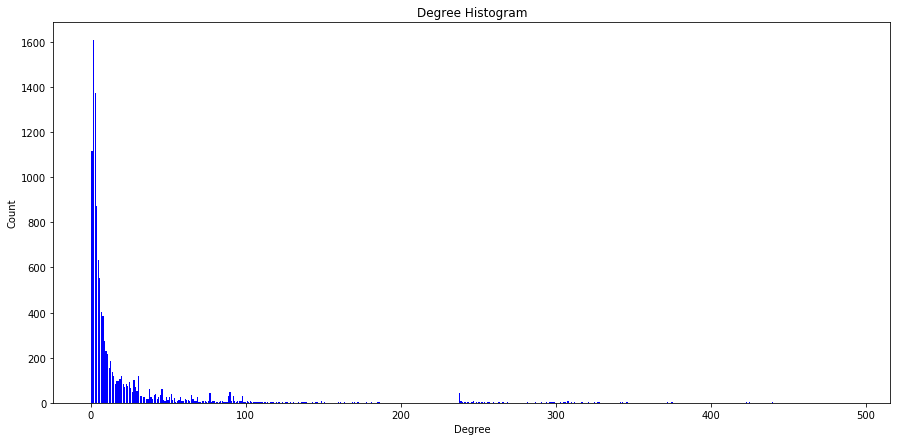

In [33]:
import collections
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(15,7))
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
#ax.set_xticks([d + 0.4 for d in deg])
#ax.set_xticklabels(deg)
print()

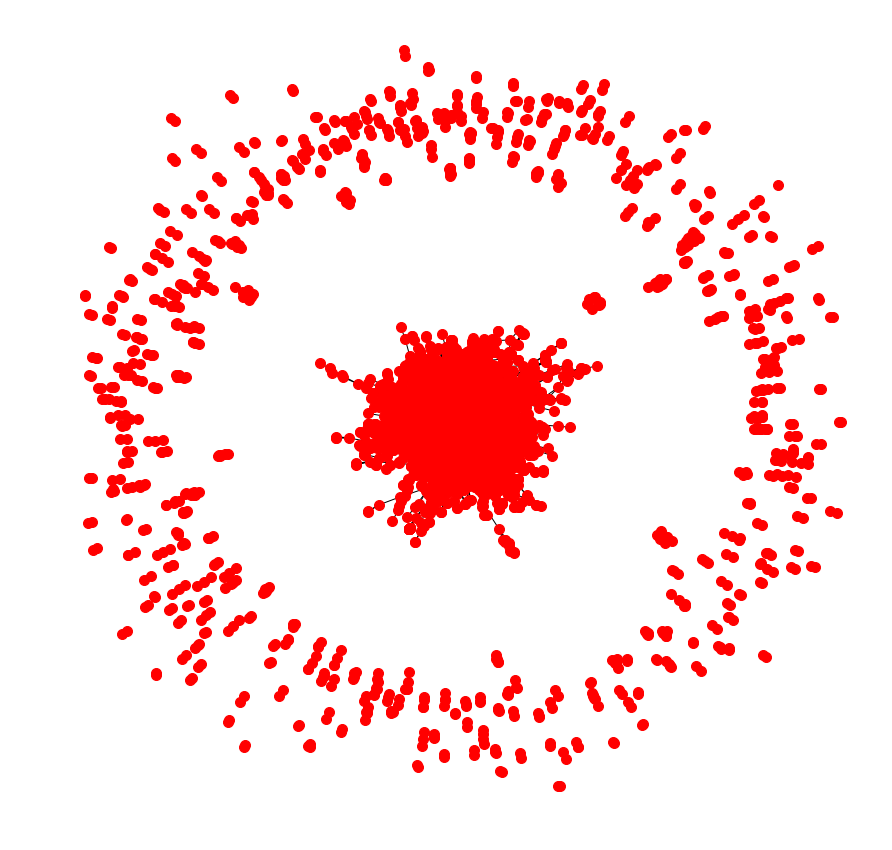

In [13]:
# Plot graph
fig, ax = plt.subplots(1,1, figsize=(15,15))
nx.draw(graph, with_labels=False, ax=ax, node_size=100) # Warning: takes a long time to run

In [16]:
k = 5

In [28]:
# Benchmark against sklearn 
labels = spectral_clustering(adjacency_matrix, n_clusters=k, eigen_solver='arpack')
print(helpers.objective_function(graph_data, labels))
print(np.unique(labels, return_counts=True))

14.3
(array([0, 1, 2, 3, 4], dtype=int32), array([9966,   10,  158,  248,  288]))


In [17]:
importlib.reload(helpers)
# Do spectral cluster alg
C_labels = helpers.spectral_cluster(adjacency_matrix=adjacency_matrix, k=k, normalized=True, random_state=0)
print(helpers.objective_function(graph_data, C_labels))
print(np.unique(C_labels, return_counts=True))

67.0
(array([0, 1, 2, 3, 4], dtype=int32), array([10659,     1,     1,     1,     8]))


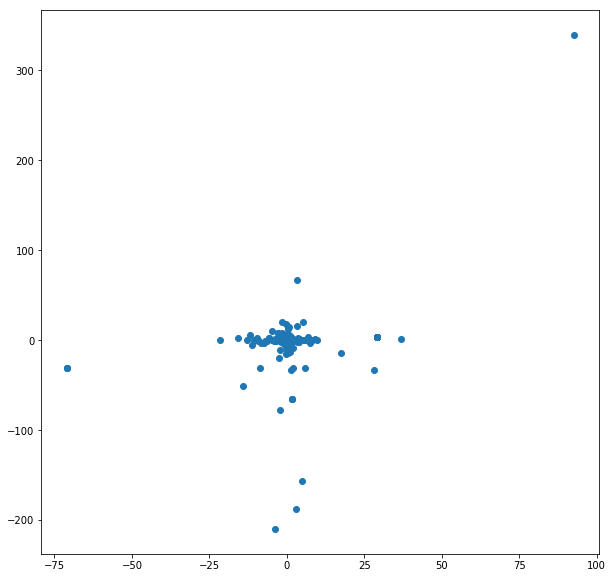

In [38]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.scatter(U_norm[:,0], U_norm[:,1])

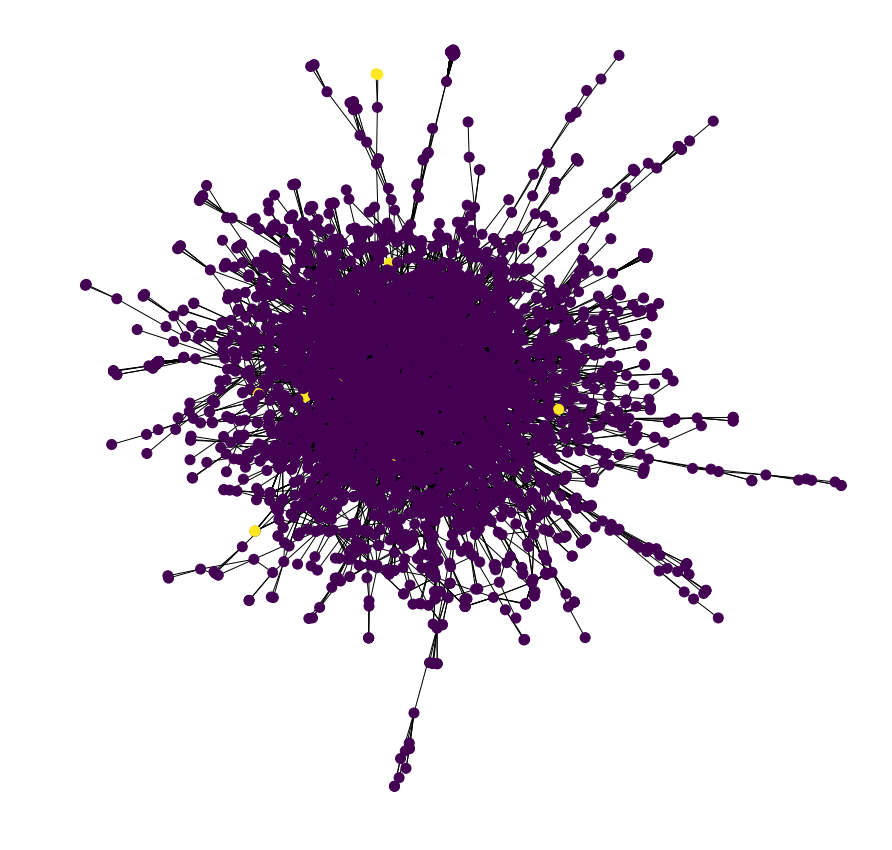

In [8]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
nx.draw(graph, with_labels=False, ax=ax, node_size=100, node_color=C_labels) 

In [29]:
importlib.reload(helpers)
# Do spectral cluster alg
B_labels = helpers.spectral_cluster(adjacency_matrix=adjacency_matrix, k=k, normalized=True, cluster_alg=helpers.BalancedKMeans, random_state=0, graph_data=graph_data)
print(helpers.objective_function(graph_data, B_labels))
print(np.unique(B_labels, return_counts=True))

Change less than 0.000001. Episode:  7
4.2126760563380286
(array([0, 1, 2, 3, 4]), array([2135, 2135, 2135, 2130, 2135]))


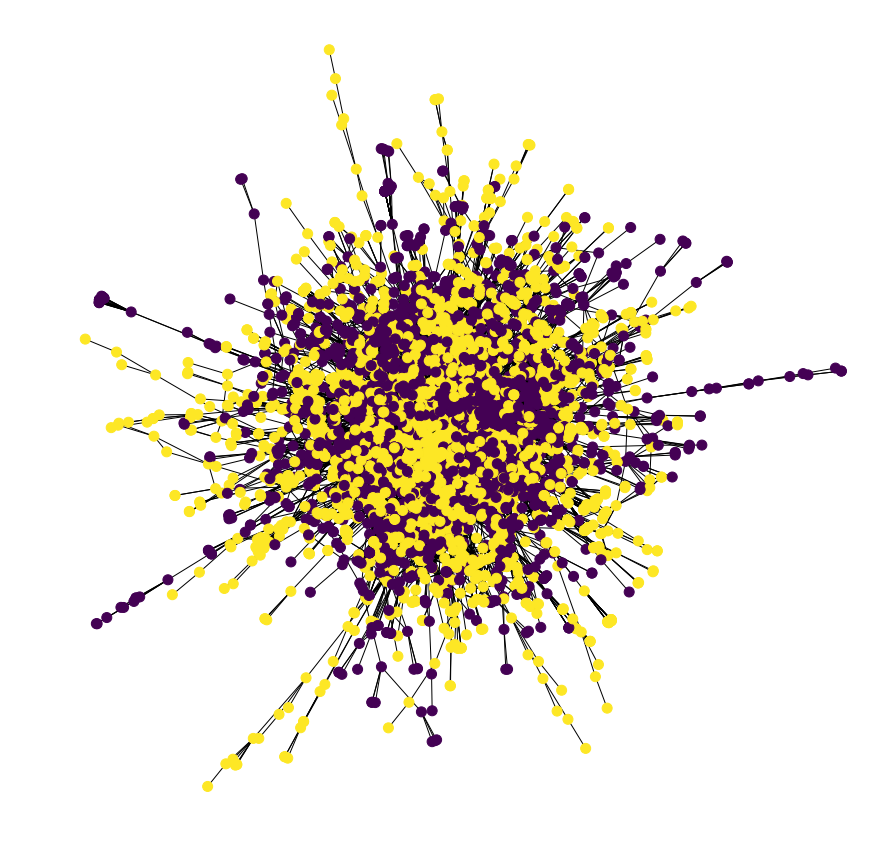

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
nx.draw(graph, with_labels=False, ax=ax, node_size=100, node_color=B_labels) 

In [96]:
laplacian, dd = scipy.sparse.csgraph.laplacian(adjacency_matrix, normed=True,
                                      return_diag=True)

In [121]:
L_nx = nx.normalized_laplacian_matrix(graph)

In [117]:
np.asarray(L)

<11204x11204 sparse matrix of type '<class 'numpy.float64'>'
	with 246442 stored elements in Compressed Sparse Row format>

In [104]:
np.sum(abs(L - laplacian) > 0.1)

10

In [123]:
laplacian *= -1
lambdas, diffusion_map = scipy.sparse.linalg.eigsh(laplacian, k=13,
                                sigma=1.0, which='LM',
                                tol=0.0)


In [106]:
diffusion_map.shape

(11204, 13)

In [112]:
diffusion_map.T[13::-1].shape

(13, 11204)

In [110]:
a = [1,2,3]
a[1::-1]

[2, 1]

In [113]:
diffusion_map.T

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [119]:
A = adjacency_matrix
D = helpers.calculate_degree_mat(A)

L = helpers.calculate_normalized_laplacian(A,D)


In [10]:
test_C = np.load('Oregon-1_spinglass_clusters.npy')

In [11]:
len(adjacency_matrix)

10670

In [12]:
len(test_C)

10670

In [13]:
np.unique(test_C)

array([0, 1, 2, 3, 4])

In [14]:
print(helpers.objective_function(graph_data, test_C))
print(np.unique(test_C, return_counts=True))

3.1866501854140914
(array([0, 1, 2, 3, 4]), array([2251, 2038, 2451, 1618, 2312]))


In [3]:
## Process graph files for the fast community alg
import os
graph_file = "Oregon-1.txt"

path = os.path.join('./graphs_processed', graph_file)

graph_data = []

lines = []
with open(path, 'r') as f:
    header = f.readline().rstrip() # rstrip removes trailing newline
    for line in f:
        line_strip = line.rstrip()
        components = line_strip.split(' ')
        
        lines.append('\t'.join(components))

In [6]:
with open('../fast-community/oregon.pairs', 'w') as f:
    for item in lines:
        f.write("%s\n" % item)
